In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
import cartopy as cy
import cartopy.crs as ccrs
from AR_occurence3550 import ar3550
from importcmip import cm245_3550
from importcmip import aod245_3550
import s3fs
xr.set_options(display_style='html')
import intake
import cftime
from netCDF4 import Dataset
from matplotlib.colors import LogNorm
import matplotlib.path as mpath
from matplotlib import rc,animation
from matplotlib.animation import FuncAnimation
from IPython import display


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [11]:
ar3550

<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, time: 5475)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) object 2035-01-01 12:00:00 ... 2049-12-31 12:00:00
Data variables:
    ivt      (lat, time, lon) bool False False False False ... False False False

In [12]:
cm245_3550

<xarray.Dataset>
Dimensions:    (member_id: 1, time: 5840, lat: 96, lon: 144, bnds: 2, plev: 8)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(96, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(144, 2), meta=np.ndarray>
  * time       (time) object 2035-01-01 12:00:00 ... 2050-12-31 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(5840, 2), meta=np.ndarray>
  * member_id  (member_id) <U8 'r1i1p1f1'
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    clt        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 1205, 96, 144), meta=np.ndarray>
    hus        (member_id, time, plev, lat, lon) float32 dask.array<chunksize=(1, 80, 8, 96, 144), meta=np.ndarray>
    pr         (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 190, 96, 144), meta=np.ndarray>
    tas        (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 305, 96, 144), meta=np.ndarray>
    va         (member_id, time, plev, lat, lon) float32 dask.array<chunksize=(1, 136, 8, 96, 144), meta=np.ndarray>
Attributes: (12/54)
    external_variables:        areacella
    physics_index:             1
    parent_mip_era:            CMIP6
    netcdf_tracking_ids:       hdl:21.14100/ab624c9a-12a7-43da-b6bf-b42b9e949...
    branch_time:               0.0
    nominal_resolution:        250 km
    ...                        ...
    sub_experiment:            none
    product:                   model-output
    model_id:                  NorESM2-LM
    realm:                     atmos
    contact:                   Please send any requests or bug reports to nor...
    intake_esm_dataset_key:    ScenarioMIP.NCC.NorESM2-LM.ssp245.day.gn

In [13]:
aod245_3550

<xarray.Dataset>
Dimensions:     (time: 5840, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time        (time) object 2035-01-01 12:00:00 ... 2050-12-31 12:00:00
  * lat         (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon         (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    wavelength  float64 550.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds   (time, bnds) object dask.array<chunksize=(2190, 2), meta=np.ndarray>
    lat_bnds    (time, lat, bnds) float64 dask.array<chunksize=(2190, 96, 2), meta=np.ndarray>
    lon_bnds    (time, lon, bnds) float64 dask.array<chunksize=(2190, 144, 2), meta=np.ndarray>
    od550aer    (time, lat, lon) float32 dask.array<chunksize=(2190, 96, 144), meta=np.ndarray>
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               ScenarioMIP
    branch_method:             Hybrid-restart from year 2015-01-01 of historical
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     60225.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               od550aer
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/95a1155d-3741-472f-b7ef-3487221d4692

In [67]:
d245_3550 = cm245_3550.merge(aod245_3550.drop(('lat_bnds', 'time_bnds', 'lon_bnds')))
arc = d245_3550.sel(lat = slice(50,90))
ant =d245_3550.sel(lat = slice(-90,-50))

In [68]:
marc = arc.where(ar3550['ivt'] == True)
mant = ant.where(ar3550['ivt'] == True)

In [82]:
#arctic
    # vapor
mintvapor = marc['hus'].mean('time').sum('plev')
intvapor = arc['hus'].mean('time').sum('plev')

    #precipitation
mprec = marc['pr'].mean('time')
prec = arc['pr'].mean('time')

    # cloud cover
mcc = marc['clt'].mean('time')
cc = arc['clt'].mean('time')


    # temp
mtemp = marc['tas'].mean('time')
temp = arc['tas'].mean('time')

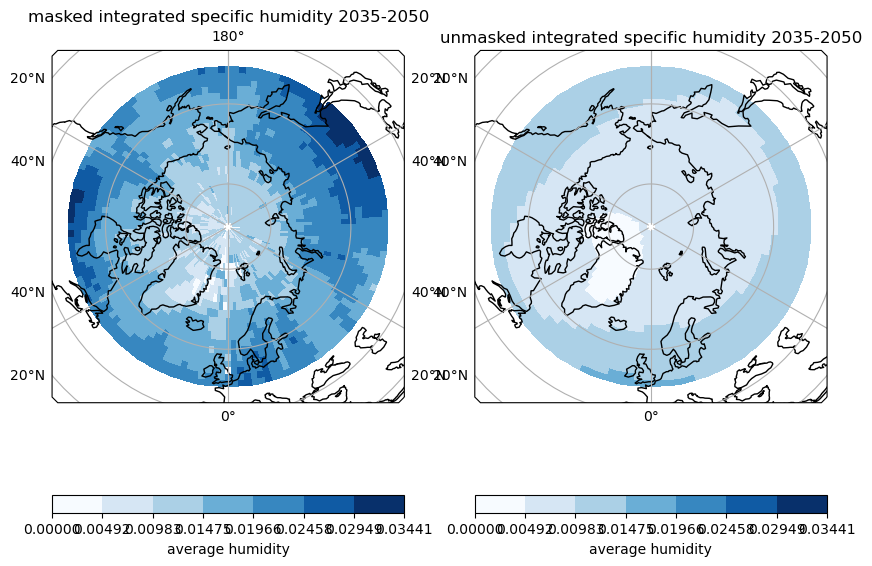

In [98]:
f,ax = plt.subplots(1,2, dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})

mintvapor.squeeze().plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax[0], vmin = 0, vmax = mintvapor.max(),
    cbar_kwargs={
        'label':'average humidity', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)
intvapor.squeeze().plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax[1], vmin = 0, vmax = mintvapor.max(),
    cbar_kwargs={
        'label':'average humidity', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)

ax[0].set_title('masked integrated specific humidity 2035-2050')
ax[1].set_title('unmasked integrated specific humidity 2035-2050')
ax[0].coastlines()
ax[1].coastlines()

gl = ax[0].gridlines(draw_labels=True)
gl = ax[1].gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

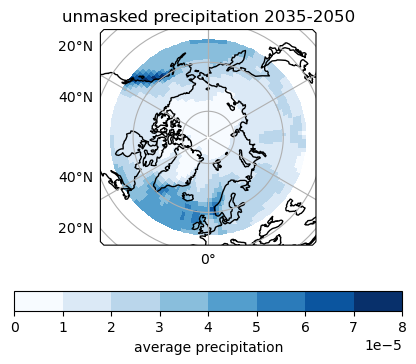

In [86]:
f,ax = plt.subplots(dpi=100, figsize =(5,4),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
prec.squeeze().plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'average precipitation', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)
ax.set_title('unmasked precipitation 2035-2050')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

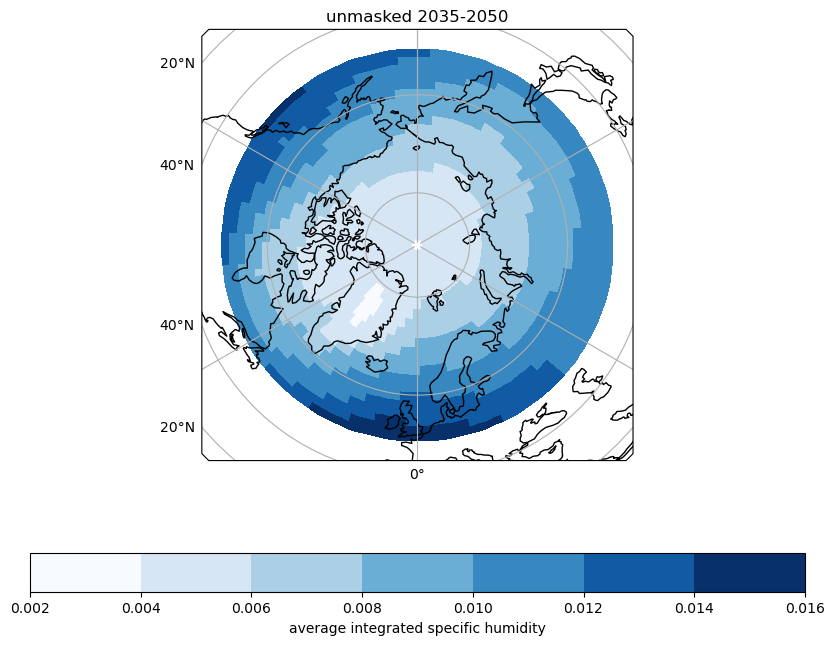

In [80]:
f,ax = plt.subplots(dpi=100, figsize =(5,4),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
intvapor.squeeze().plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'average integrated specific humidity', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)
ax.set_title('unmasked 2035-2050')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

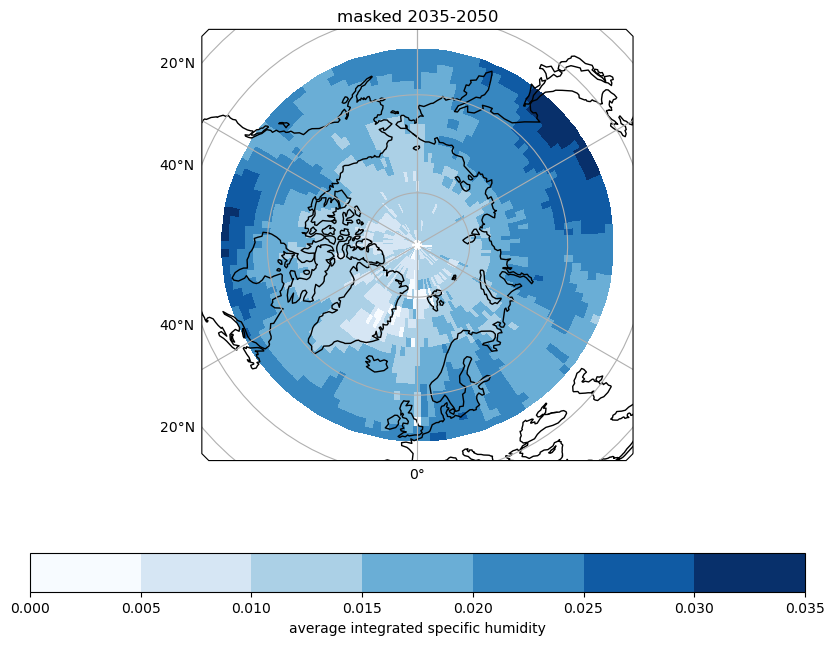

In [81]:
f,ax = plt.subplots(dpi=100, figsize =(10,8),
                    subplot_kw={'projection':ccrs.Orthographic(central_latitude=90.0)})
mintvapor.squeeze().plot.pcolormesh(
    cmap = plt.get_cmap('Blues'),ax=ax,
    cbar_kwargs={
        'label':'average integrated specific humidity', 
        'orientation':'horizontal',
        
    },
    transform=ccrs.PlateCarree(), 
    x='lon',y='lat',
    levels = 8
)
ax.set_title('masked 2035-2050')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False